In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ny_property = pd.read_csv('NY property data.csv')
ny_prop = ny_property.copy()
ny_property.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


In [3]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 
        summary.loc[summary['Name'] == name,'Most Common Field Value']=df[name].value_counts().index[0]

    return summary

In [4]:
# take a look at the general image of the data
resumetable(ny_property)

Dataset Shape: (1070994, 32)


,Name,dtypes,Missing,Uniques,Entropy,Most Common Field Value
0,RECORD,int64,0,1070994,20.03,2047
1,BBLE,object,0,1070994,20.03,5015970105
2,B,int64,0,5,2.15,4
3,BLOCK,int64,0,13984,13.13,3944
4,LOT,int64,0,6366,8.31,1
5,EASEMENT,object,1066358,12,0.68,E
6,OWNER,object,31745,863347,19.29,PARKCHESTER PRESERVAT
7,BLDGCL,object,0,200,4.75,R4
8,TAXCLASS,object,0,11,1.81,1
9,LTFRONT,int64,0,1297,5.09,0


### Fill in Missing Value

In [5]:
#filling in missing value for ZIP
missing_zips = np.where(pd.isnull(ny_property['ZIP']))[0]
len(missing_zips)

29890

In [6]:
# records are sorted by zip, hence if zip before and after the missing record is the same, 
# then fill in with that zip
for i in range(len(missing_zips)):
    if(ny_property.loc[missing_zips[i]+1,'ZIP'] == ny_property.loc[missing_zips[i]-1,'ZIP']):
        ny_property.loc[missing_zips[i],'ZIP'] = ny_property.loc[missing_zips[i]-1,'ZIP']

In [7]:
missing_zips = np.where(pd.isnull(ny_property['ZIP']))[0]
len(missing_zips)

16437

In [8]:
# fill in rest of the missing zips with the zip from the record above
for i in range(len(missing_zips)):
    ny_property.loc[missing_zips[i],'ZIP'] = ny_property.loc[missing_zips[i]-1,'ZIP']

In [9]:
missing_zips = np.where(pd.isnull(ny_property['ZIP']))[0]
len(missing_zips)

0

In [10]:
# filling in missing value for STORIES
temp = ny_property[ny_property['STORIES'].isnull()]
len(temp)

56264

In [11]:
# groupby TAXCLASS to fill in missing value
temp['TAXCLASS'].value_counts()

1B    24736
4     22354
3      4635
2      3435
1       897
2C      138
2B       34
2A       30
1A        5
Name: TAXCLASS, dtype: int64

In [12]:
mean_stories = ny_property.groupby('TAXCLASS')['STORIES'].mean()
print(mean_stories)

TAXCLASS
1      2.111641
1A     1.656837
1B     4.000000
1C     3.052748
1D     1.068966
2     16.095110
2A     2.844574
2B     4.004494
2C     4.745097
3      1.333333
4      5.446968
Name: STORIES, dtype: float64


In [13]:
len(ny_property[ny_property['STORIES']==0])

0

In [14]:
ny_property['STORIES']=ny_property['STORIES'].fillna(0)
for i in mean_stories.index:
    ny_property.loc[(ny_property['STORIES']==0)&(ny_property['TAXCLASS']==i),'STORIES'] = mean_stories[i]

In [15]:
# filling in missing value for FULLVAL, AVLAND, AVTOT
# calculate means for these three fields by TAXCLASS
ny_property['FULLVAL'].replace('NaN',0)
temp = ny_property[ny_property['FULLVAL']!=0]
mean_fullval = temp.groupby('TAXCLASS')['FULLVAL'].mean()
print(mean_fullval)

TAXCLASS
1     5.698435e+05
1A    3.352842e+05
1B    5.613639e+05
1C    7.615359e+05
1D    2.233614e+07
2     7.998018e+05
2A    8.640037e+05
2B    1.252989e+06
2C    7.728799e+05
3     1.112765e+05
4     3.211928e+06
Name: FULLVAL, dtype: float64


In [16]:
ny_property['AVLAND'].replace('NaN',0)
temp_avland = ny_property[ny_property['AVLAND']!=0]
mean_avland = temp_avland.groupby('TAXCLASS')['AVLAND'].mean()
print(mean_avland)

TAXCLASS
1      14896.433976
1A      2247.369138
1B     14781.268478
1C      8225.658898
1D    709303.793103
2      90830.095031
2A     31363.390619
2B     54446.810503
2C     25639.066531
3      43368.352941
4     600949.433397
Name: AVLAND, dtype: float64


In [17]:
ny_property['AVTOT'].replace('NaN',0)
temp_avtot = ny_property[ny_property['AVTOT']!=0]
mean_avtot = temp_avtot.groupby('TAXCLASS')['AVTOT'].mean()
print(mean_avland)

TAXCLASS
1      14896.433976
1A      2247.369138
1B     14781.268478
1C      8225.658898
1D    709303.793103
2      90830.095031
2A     31363.390619
2B     54446.810503
2C     25639.066531
3      43368.352941
4     600949.433397
Name: AVLAND, dtype: float64


In [18]:
%%time
for i in mean_fullval.index:
    ny_property.loc[(ny_property['FULLVAL']==0)&\
                    (ny_property['TAXCLASS']==i),'FULLVAL'] = mean_fullval[i]
    ny_property.loc[(ny_property['AVLAND']==0)&\
                    (ny_property['TAXCLASS']==i),'AVLAND'] = mean_avland[i]
    ny_property.loc[(ny_property['AVTOT']==0)&\
                    (ny_property['TAXCLASS']==i),'AVTOT'] = mean_avtot[i]

CPU times: user 1.86 s, sys: 50.8 ms, total: 1.91 s
Wall time: 1.91 s


In [19]:
# as these 4 values do not have NAs, we just need to replace 0s. 
# calculate groupwise average. 1st replace 0 by NAs so they are not counted in calculating mean.
ny_property.loc[ny_property['LTFRONT']==0,'LTFRONT']=np.nan
ny_property.loc[ny_property['LTDEPTH']==0,'LTDEPTH']=np.nan
ny_property.loc[ny_property['BLDFRONT']==0,'BLDFRONT']=np.nan
ny_property.loc[ny_property['BLDDEPTH']==0,'BLDDEPTH']=np.nan


In [20]:
# calculate mean now (mean function ignores NAs but not 0s hence we converted 0 to NA)
mean_LTFRONT=ny_property.groupby(ny_property['TAXCLASS'])['LTFRONT'].mean()
mean_LTDEPTH=ny_property.groupby(ny_property['TAXCLASS'])['LTDEPTH'].mean()
mean_BLDFRONT=ny_property.groupby(ny_property['TAXCLASS'])['BLDFRONT'].mean()
mean_BLDDEPTH=ny_property.groupby(ny_property['TAXCLASS'])['BLDDEPTH'].mean()


In [21]:
# imput values
for i in mean_LTFRONT.index:
    ny_property.loc[(ny_property['LTFRONT'].isnull())&\
                    (ny_property['TAXCLASS']==i),'LTFRONT']=mean_LTFRONT[i]    
    ny_property.loc[(ny_property['LTDEPTH'].isnull())&\
                    (ny_property['TAXCLASS']==i),'LTDEPTH']=mean_LTDEPTH[i]
    ny_property.loc[(ny_property['BLDFRONT'].isnull())&\
                    (ny_property['TAXCLASS']==i),'BLDFRONT']=mean_BLDFRONT[i]
    ny_property.loc[(ny_property['BLDDEPTH'].isnull())&\
                    (ny_property['TAXCLASS']==i),'BLDDEPTH']=mean_BLDDEPTH[i]


### Create new variables

In [22]:
#convert zip to integer rather than a float
ny_property['ZIP'] = ny_property['ZIP'].astype(str)
ny_property['zip3'] = ny_property['ZIP'].str[:3]

In [23]:
ny_property['ltsize'] = ny_property['LTFRONT'] * ny_property['LTDEPTH']
ny_property['bldsize'] = ny_property['BLDFRONT'] * ny_property['BLDDEPTH']
ny_property['bldvol'] = ny_property['bldsize'] * ny_property['STORIES']

In [24]:
# create measure of how normal a property is
ny_property['r1'] = ny_property['FULLVAL'] / ny_property['ltsize']
ny_property['r2'] = ny_property['FULLVAL'] / ny_property['bldsize']
ny_property['r3'] = ny_property['FULLVAL'] / ny_property['bldvol']
ny_property['r4'] = ny_property['AVLAND'] / ny_property['ltsize']
ny_property['r5'] = ny_property['AVLAND'] / ny_property['bldsize']
ny_property['r6'] = ny_property['AVLAND'] / ny_property['bldvol']
ny_property['r7'] = ny_property['AVTOT'] / ny_property['ltsize']
ny_property['r8'] = ny_property['AVTOT'] / ny_property['bldsize']
ny_property['r9'] = ny_property['AVTOT'] / ny_property['bldvol']


In [25]:
ninevars = ['r1','r2','r3','r4','r5','r6','r7','r8','r9']
zip5_mean = ny_property.groupby('ZIP')[ninevars].mean()
zip3_mean = ny_property.groupby('zip3')[ninevars].mean()
taxclass_mean = ny_property.groupby('TAXCLASS')[ninevars].mean()
borough_mean = ny_property.groupby('B')[ninevars].mean()
#join the new variable to table
ny_property = ny_property.join(zip5_mean, on = 'ZIP', rsuffix= '_zip5')
ny_property = ny_property.join(zip3_mean, on = 'zip3', rsuffix= '_zip3')
ny_property = ny_property.join(taxclass_mean, on = 'TAXCLASS', rsuffix= '_taxclass')
ny_property = ny_property.join(borough_mean, on = 'B', rsuffix= '_boro')
rsuffix = ['_zip5','_zip3','_taxclass','_boro']
for var in ninevars:
    for r in rsuffix:
        ny_property[str(var)+r] = ny_property[var] / ny_property[str(var)+r]

In [26]:
list1 = []
list1.append('RECORD')
for var in ninevars:
    list1.append(str(var))
    for r in rsuffix:
        list1.append(str(var)+r)


In [27]:
data=ny_property.copy()

In [28]:
# drop other variables except the ones created
for col in data.columns:
    if col not in list1:
        data = data.drop(col,1)

In [29]:
data.head()

,RECORD,r1,r2,r3,r4,r5,r6,r7,r8,r9,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
0,1,40.917782,3784.190253,694.733351,8.079350,747.200744,137.177373,18.413002,1702.885614,312.630008,...,2.624110,0.114401,6.878229,4.993136,0.234725,11.759224,6.071127,0.197696,11.818277,9.069199
1,2,53655.384245,34269.909866,6291.557172,3961.860416,2530.456193,464.562348,24144.922910,15421.459440,2831.200728,...,23.764139,150.013517,62.289753,45.218210,115.101891,39.823571,20.560366,259.238195,107.027200,82.131345
2,3,261.796157,261.796157,87.265386,97.551991,97.551991,32.517330,117.808271,117.808271,39.269424,...,0.329614,0.731948,0.475847,0.627187,2.834128,1.535244,1.439136,1.264879,0.817607,1.139181
3,4,89.714219,836.980890,418.490445,34.913021,325.717946,162.858973,40.371399,376.641401,188.320700,...,1.580700,0.250829,1.521315,3.007743,1.014310,5.126053,7.207730,0.433458,2.613947,5.463065
4,5,669.074647,53676.325646,53676.325646,297.434763,23861.620343,23861.620343,301.083591,24154.346541,24154.346541,...,202.743398,1.870646,97.563288,385.778484,8.641219,375.527127,1056.055550,3.232662,167.634723,700.702336


In [30]:
stats = data.describe().transpose()

In [31]:
stats.to_excel('stats_on_vars.xlsx')

In [32]:
#z scale the variables before PCA
data_orig = data.copy()
data.drop(columns='RECORD',inplace=True)

In [33]:
data = (data-data.mean())/data.std()

(0.0, 1.0)

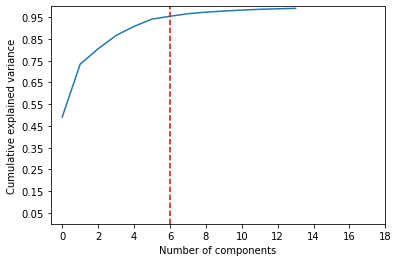

In [34]:
#compute PC components and look at the screen plot

#If 0 < n_components < 1 and svd_solver == 'full', 
#select the number of components such that the amount of variance that needs 
#to be explained is greater than the percentage specified by n_components.
pca = PCA(n_components = 0.99,svd_solver = 'full')
pca.fit(data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 20, step=2))
plt.axvline(x=6, linestyle='--',color='red')
plt.ylim(0,1)

In [35]:
#decide to keep 6 PCs
pca = PCA(n_components = 6)
princ_comps = pca.fit_transform(data)
data_pca = pd.DataFrame(princ_comps,columns = ['PC'+str(i) for i in range(1,pca.n_components_+1)])
data_pca.shape

(1070994, 6)

In [36]:
#z scale the PC 
pca_mean=data_pca.mean()
pca_sd=data_pca.std()
data_pca=(data_pca-pca_mean)/pca_sd
data_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06
mean,-2.665924e-18,-4.002954e-16,5.165011e-17,4.714516e-17,2.388794e-16,-4.783743e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-5.423878e-02,-1.387192e+02,-4.465509e+02,-3.631831e+02,-3.499267e+02,-3.352532e+02
25%,-2.844246e-02,-6.242250e-02,-7.041944e-03,-8.103322e-02,-5.505848e-02,-3.206240e-02
50%,-1.044346e-02,-2.825168e-02,1.778053e-03,-3.531658e-03,-1.110122e-02,-1.197026e-03
75%,3.780853e-04,4.758921e-03,1.667827e-02,3.730556e-02,1.083306e-02,5.639531e-02
max,8.006021e+02,5.359121e+02,4.807969e+02,4.084298e+02,4.391587e+02,4.292597e+02


In [37]:
# Model 1
# choose the power in the Euclidean distance to be 2
p = 2
one_over_p = 1/p
score1 = (((data_pca).abs()**p).sum(axis = 1))**one_over_p

In [38]:
# Model 2: autoencoder error
from keras.models import Model
from keras.layers import Input,Dense

In [39]:
# compress the data records from 6 to 3 dimensions, then expand them back to 6 dimensions
# placeholder for input
data_in = Input(shape=(6,))
# choose 3 as dimension of the encoded data
encoded_dim = 3
#encoded representation of the data
encoded = Dense(encoded_dim,activation = 'tanh')(data_in)
# reconstruction of the input
decoded = Dense(6,activation='tanh')(encoded)
# this model maps the input data to the reconstructed data
autoencoder = Model(data_in, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(data_pca,data_pca, epochs=5, shuffle=True, validation_data=(data_pca,data_pca))
# choose the power in the Euclidean distance to be 2 again
pca_out = autoencoder.predict(data_pca)
error = pca_out - data_pca
p=2
oop=1/p
score2 = ((error.abs()**p).sum(axis=1))**oop

Epoch 1/5
33469/33469 [==============================] - 29s 847us/step - loss: 0.9706 - val_loss: 0.9766
Epoch 2/5
33469/33469 [==============================] - 29s 853us/step - loss: 0.8719 - val_loss: 0.9750
Epoch 3/5
33469/33469 [==============================] - 28s 825us/step - loss: 0.9897 - val_loss: 0.9747
Epoch 4/5
33469/33469 [==============================] - 27s 806us/step - loss: 0.9385 - val_loss: 0.9746
Epoch 5/5
33469/33469 [==============================] - 30s 892us/step - loss: 0.6545 - val_loss: 0.9745


In [40]:
# average the 2 score raking 
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores['final'] = (scores['score1 rank'] + scores['score2 rank'])/2
top_records = scores.sort_values(['final'], ascending = False).head(20).index


In [41]:
final_df = ny_prop.join(scores)
final_df

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1,score2,score1 rank,score2 rank,final
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,8613000.0,NaN,FINAL,2010/11,AC-TR,0.571141,0.440146,1046560.0,1059831.0,1053195.5
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,80690400.0,NaN,FINAL,2010/11,AC-TR,24.684915,23.135544,1070739.0,1070738.0,1070738.5
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,40179510.0,NaN,FINAL,2010/11,AC-TR,0.152792,0.100953,726630.0,1008652.0,867641.0
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,15750000.0,NaN,FINAL,2010/11,AC-TR,0.169596,0.119289,787272.0,1020880.0,904076.0
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,107758350.0,NaN,FINAL,2010/11,AC-TR,30.244381,28.881174,1070777.0,1070785.0,1070781.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070989,1070990,5080500083,5,8050,83,NaN,"TOBIN, GALE",A1,1,60,...,NaN,NaN,FINAL,2010/11,AC-TR,0.106922,0.036209,595911.0,829938.0,712924.5
1070990,1070991,5080500086,5,8050,86,NaN,SHERRI MILINAZZO,A1,1,62,...,NaN,NaN,FINAL,2010/11,AC-TR,0.123535,0.039737,645344.0,858579.0,751961.5
1070991,1070992,5080500089,5,8050,89,NaN,JOHN GERVASI,A1,1,53,...,NaN,1017.0,FINAL,2010/11,AC-TR,0.120233,0.031719,636542.0,769679.0,703110.5
1070992,1070993,5080500092,5,8050,92,NaN,RITA M MOOG,A1,1,52,...,NaN,NaN,FINAL,2010/11,AC-TR,0.106143,0.033412,593061.0,798725.0,695893.0


In [42]:
# export top 20 records
records_to_return = final_df.sort_values(['final'], ascending = False).head(20)
records_to_return.to_excel('Top 20 records.xlsx')


(0.1, 2142747.525661616)

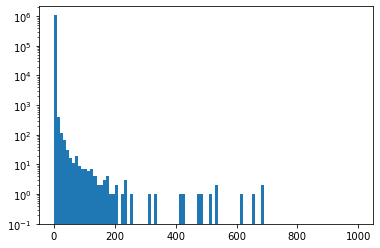

In [43]:
# plots of scores
plt.hist(score1,bins=100,range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=0.1)

(0.1, 2142980.8651350504)

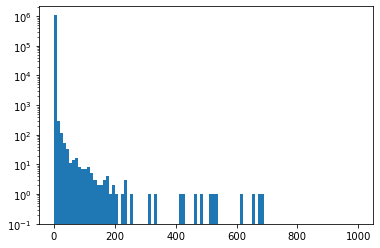

In [44]:
plt.hist(score2,bins=100,range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=0.1)

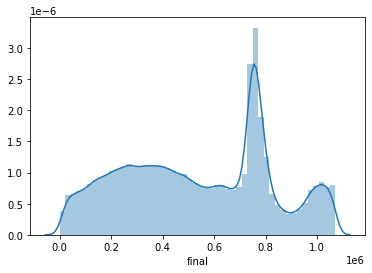

In [45]:
sns.distplot(scores['final'])